In [427]:
import sys
sys.path.append('..')
import itertools, copy
import re
import json
import numpy as np
import scipy.misc
from scipy.stats import binom
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

plt.style.use('../peptidome.mplstyle')

from lib import *
from lib.maxent import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [428]:
humanseqs = [s for s in fasta_iter(human, returnheader=False)]


In [429]:
train, test = train_test_split(humanseqs, test_size=0.5)


In [430]:
k = 3


In [431]:
kmers = [''.join(s) for s in itertools.product(aminoacids, repeat=k)]
df = pd.DataFrame.from_dict(dict(seq=kmers, freq=np.zeros(len(kmers))))
df.set_index('seq', inplace=True)
df['freq'] = df.add(count(train, k), fill_value=0.0)
df['freq_test'] = np.zeros(len(kmers))
df['freq_test'] = df['freq_test'].add(count(test, k)['freq'], fill_value=0.0)
jsd_test = calc_jsd(df['freq_test'], df['freq'])
jsd_flat = calc_jsd(df['freq_test'], np.ones_like(df['freq']), base=2)


#df_test.set_index('seq', inplace=True)
#df_count = counter_to_df(count_kmers_iterable(test, k), norm=False)
#df_count.set_index('seq', inplace=True)
#df_test = df_test.add(df_count, fill_value=0.0)
#df_test['freq'] = df_test['count'] / np.sum(df_test['count'])


tripletparams = calc_tripletmodelparams(train)
#kmers = df.index
df['freq_ind'] = np.array([10**(loglikelihood_independent(s, **tripletparams)) for s in kmers])
df['freq_mc'] = np.array([10**(loglikelihood_mc(s, **tripletparams)) for s in kmers])
df['freq_tri'] = np.array([10**(loglikelihood_triplet(s, **tripletparams)) for s in kmers])
jsd_ind = calc_jsd(df['freq_test'], df['freq_ind'], base=2)
jsd_mc = calc_jsd(df['freq_test'], df['freq_mc'], base=2)
jsd_tri = calc_jsd(df['freq_test'], df['freq_tri'], base=2)

In [432]:
aacountss = []
#for seq in np.random.choice(humanseqs, 1000, replace=False):
for seq in train:
    seq = seq.strip('X')
    if not isvalidaa(seq):
        seq = re.sub('X|U', '', seq)
        if not isvalidaa(seq):
            print(seq)
    seq = map_aatonumber(seq)
    for i in range(len(seq)-k):
        #if isvalidaa(seq[i:i+k]):
        #print(seq[i:i+k], aacounts(seq[i:i+k]))
        aacountss.append(aacounts_int(seq[i:i+k]))

In [ ]:
aafreqs

A 0.06996142799603539 [0.80968332 0.17191753 0.01723068 0.00116847]
C 0.022987171805945703 [9.33251950e-01 6.45807850e-02 2.12105337e-03 4.62112699e-05]
D 0.04752083352072876 [8.65236848e-01 1.27209834e-01 7.30727676e-03 2.46040928e-04]
E 0.07090366687719624 [0.80858117 0.17145032 0.01864483 0.00132367]
F 0.036646607860660346 [8.94731741e-01 1.00672173e-01 4.52059662e-03 7.54890486e-05]
G 0.06564995170048339 [8.18478119e-01 1.66879460e-01 1.38568570e-02 7.85563369e-04]
H 0.026372753040700168 [9.23559418e-01 7.38535513e-02 2.49637333e-03 9.06570544e-05]
I 0.0433956650191743 [8.76438068e-01 1.17059792e-01 6.37920645e-03 1.22933160e-04]
K 0.057558408434069765 [8.40977210e-01 1.45911280e-01 1.25705748e-02 5.40935181e-04]
L 0.0997766128984372 [0.73160601 0.23891444 0.02802325 0.00145631]
M 0.020157633207868057 [9.40987457e-01 5.75673460e-02 1.43002724e-03 1.51697696e-05]
N 0.03606428577181663 [8.96303746e-01 9.92791857e-02 4.33752232e-03 7.95456083e-05]
P 0.0633279533944792 [0.82839852 0.15

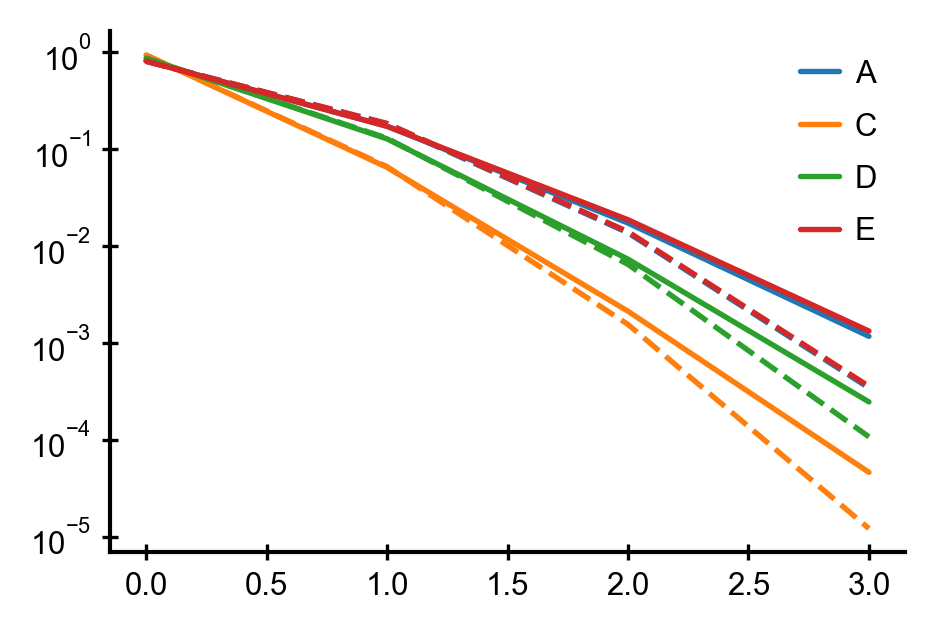

In [434]:
pseudocount = 1e-2
aafreqs = np.mean(np.asarray(aacountss), axis=0)/k
prob_aa_ks = prob_aa(aacountss, k, pseudocount=pseudocount)
for i in range(len(aminoacids)):
    aa = map_numbertoaa([i])[0]
    prob_aa_k = prob_aa_ks[i]
    print(aa, aafreqs[i], prob_aa_k)
    if i < 4:
        l, = plt.plot(prob_aa_k, label=aa)
        x = np.arange(0, k+1, 1)
        n = k
        p = aafreqs[i]
        plt.plot(x, binom.pmf(x, n, p), '--', c=l.get_color())
plt.legend()
plt.yscale('log')
fks = np.asarray(prob_aa_ks)

In [435]:
# evaluate empirical observables for fitting
df0 = count(train, 1)
df1 = count(train, 2, gap=0)
dfgap1 = count(train, 2, gap=1)
if k == 4:
    dfgap2 = count(train, 2, gap=2)

In [436]:
args = [df1, dfgap1, dfgap2] if k == 4 else [df1, dfgap1]
h, Jk = fit_ising(df0, args, nmcmc=5e5, niter=10, epsilon=0.2, N=k, output=True)

[ 0.45064363 -0.66223406  0.06333304  0.4629459  -0.19656768  0.3854325
 -0.52553527 -0.02818728  0.25583203  0.80453681 -0.73591469 -0.21272923
  0.34986356  0.065175    0.23435418  0.63313531  0.17436984  0.2898184
 -1.29639769 -0.51187429]
iteration 0
f1 1.8311327018804256e-06
f2, gap 0 0.0024731617339114604
f2, gap 1 0.0019070783123505302
iteration 1
f1 3.3900093109713984e-06
f2, gap 0 0.0015817489739268422
f2, gap 1 0.0012995759316692316
iteration 2
f1 9.268514563015938e-06
f2, gap 0 0.0010972309352332186
f2, gap 1 0.000954357059266837
iteration 3
f1 5.157987435376661e-06
f2, gap 0 0.0006972884607963435
f2, gap 1 0.0007532083623517943
iteration 4
f1 7.4022841238182986e-06
f2, gap 0 0.0005312058224422888
f2, gap 1 0.0005668540865402425
iteration 5
f1 4.800080026283236e-06
f2, gap 0 0.0004133188857749824
f2, gap 1 0.00039058110618158943
iteration 6
f1 8.770982888280625e-06
f2, gap 0 0.0002612592712186204
f2, gap 1 0.00036418114320951064
iteration 7
f1 1.0737980039005098e-05
f2, gap 

In [437]:
Z = np.exp(scipy.special.logsumexp([-clib.energy(np.array(s), h, Jk) for s in itertools.product(range(naminoacids), repeat=k)]))
df['freq_maxent'] = np.exp([-clib.energy(map_aatonumber(s), h, Jk) for s in kmers])/Z
jsd_maxent = calc_jsd(df_test['freq'], df['freq_maxent'], base=2)

In [15]:
hks = fit_global(fks, niter=10, nmcmc=1e6, epsilon=0.1, output=True)

iteration 0


KeyboardInterrupt: 

In [438]:
pseudocount = 1e-2
niter=10
nmcmc=1e6
epsilon=0.5
prng=None
output=False

N = len(fks[0])-1
if prng is None:
    prng = np.random
q = len(aminoacids)
aas_arr = np.array(list(aminoacids))
f1 = np.sum(np.arange(fks.shape[1])*fks, axis=1)/(fks.shape[1]-1)
h = np.array(np.log(f1))
h -= np.mean(h)
hks = h.reshape(20, 1)*np.arange(fks.shape[1])
#hks = np.zeros((q, N+1))
for i in range(niter):
    if output:
        print('iteration %g'%i)
#    def jump(x):
#        xp = x.copy()
#        i = np.random.randint(0, len(x))
#        xp[i] = (xp[i]+np.random.randint(0, q-1))%q
#        return xp
    def jump(x):
        return prng.randint(q, size=N)
    def energy(x):
        return energy_global(aacounts_int(x), hks)
    x0 = jump(prng.randint(q, size=N))
    samples = mcmcsampler(x0, energy, jump, nmcmc, prng=prng, nburnin=1e3)
    aacountss = [aacounts_int(s) for s in samples]
    prob_aa_ks = prob_aa(aacountss, N, pseudocount=pseudocount)
    #Z = np.exp(scipy.special.logsumexp([-energy_global(aacounts_int(np.array(s)), hks) for s in itertools.product(range(naminoacids), repeat=k)]))
    #probs = np.exp([-energy_global(aacounts(s), hks) for s in kmers])/Z
    if i == 0:
        prob_aa_ks0 = prob_aa_ks
    hks += np.log(fks/prob_aa_ks)*epsilon
    #hks += (fks-prob_aa_ks)*epsilon
    jsd = calc_jsd(fks, prob_aa_ks, base=2)
    print(jsd)

[1.10117816e-06 7.74560294e-05 1.75845336e-03 4.21032201e-02]
[4.80264514e-07 2.96191307e-05 4.47725283e-04 1.33540836e-02]
[9.00871057e-08 7.32318900e-06 1.84663381e-04 4.57381818e-03]
[1.34871083e-07 5.07726315e-06 8.89053339e-05 1.43496314e-03]
[1.03323545e-07 4.23810963e-06 6.26173221e-05 2.37524623e-03]
[1.01322380e-07 4.22541529e-06 6.09838332e-05 7.04714132e-03]
[9.27197319e-08 4.45691194e-06 7.34718428e-05 2.13776972e-03]
[1.76452037e-07 4.85923223e-06 5.10446124e-05 1.63425838e-03]


KeyboardInterrupt: 

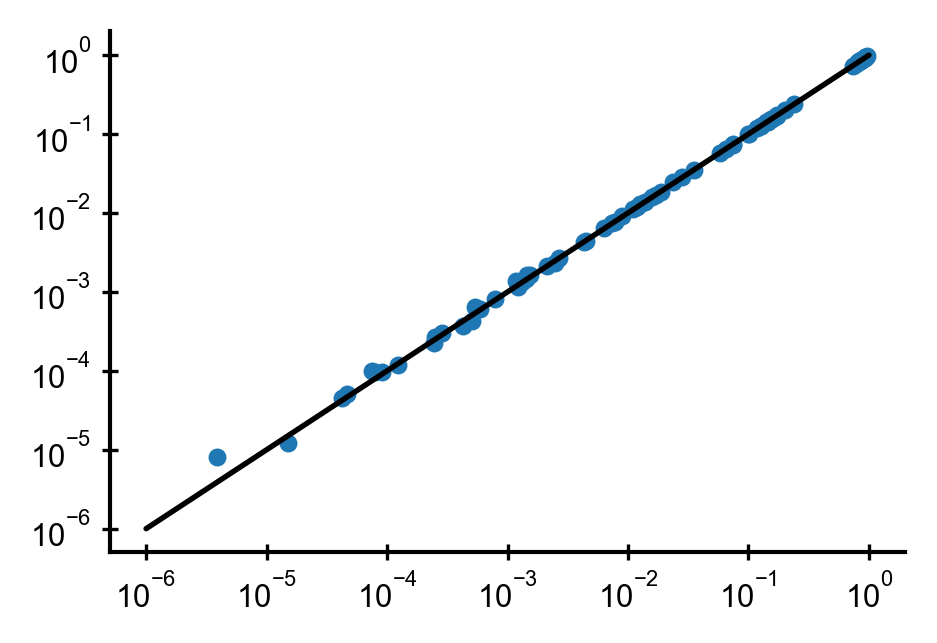

In [439]:
plt.plot(fks.flatten(), prob_aa_ks.flatten(), 'o')
x = [1e-6, 1e0]
plt.plot(x, x, 'k')
plt.xscale('log')
plt.yscale('log')

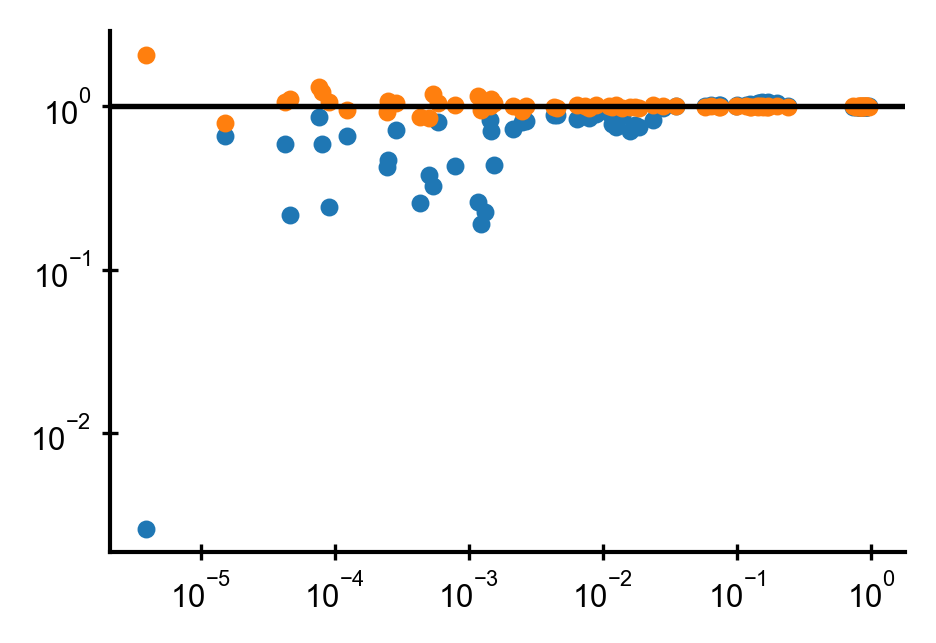

In [440]:
plt.plot(fks.flatten(), prob_aa_ks0.flatten()/fks.flatten(), 'o')
plt.plot(fks.flatten(), prob_aa_ks.flatten()/fks.flatten(), 'o')
#x = [1e-6, 1e0]
#plt.plot(x, x, 'k')
plt.axhline(1.0, c='k')
#plt.ylim(1e-1)
plt.xscale('log')
plt.yscale('log')

In [441]:
Z = np.exp(scipy.special.logsumexp(
           [-energy_global(aacounts_int(np.array(s)), hks) for s in itertools.product(range(naminoacids), repeat=k)]
           ))
df['freq_maxentglobal'] = np.exp([-energy_global(aacounts(s), hks) for s in kmers])/Z
jsd_maxentglobal = calc_jsd(df['freq_test'], df['freq_maxentglobal'], base=2)

In [442]:
entropies = {}
Smax = np.log2(20)*k
for column in df.filter(regex='freq'):
    f3 = np.array(df[column])
    entropy = scipy.stats.entropy(f3, base=2)
    print(column, Smax-entropy)
    entropies[column] = entropy

freq 0.4818228760509786
freq_test 0.4842479763025853
freq_ind 0.4325065695757271
freq_mc 0.46518219003396943
freq_tri 0.4816500946701403
freq_maxent 0.4637896156769994
freq_maxentglobal 0.4502190795582077


In [443]:
print('test', jsd_test, 'maxent', jsd_maxent, 'maxentglobal', jsd_maxentglobal,
              'flat', jsd_flat, 'ind', jsd_ind, 'mc', jsd_mc, 'tri', jsd_tri)

test 0.00045066791878147335 maxent 0.0022975074189060768 maxentglobal 0.0074488182226179825 flat 0.11636605633280683 ind 0.010787692666021382 mc 0.004270292681160973 tri 0.0006520739816125916


In [349]:
from scipy.interpolate import interpn

def density_scatter(x, y, ax=None, sort=True, bins=20, trans=None, **kwargs):
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        ax = plt.gca()
    if trans is None:
        trans = lambda x: x
    data , x_e, y_e = np.histogram2d(trans(x), trans(y), bins = bins)
    z = interpn(( 0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:]+y_e[:-1]) ),
                data, np.vstack([trans(x),trans(y)]).T,
                method="splinef2d", bounds_error=False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter(x, y, c=z, **kwargs)
    return ax

In [225]:
from scipy.stats import gaussian_kde
def scatterplot(x, y, ax=None):
    if ax is None:
        ax = plt.gca()
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    ax.scatter(x, y, c=z, s=1, edgecolor='')

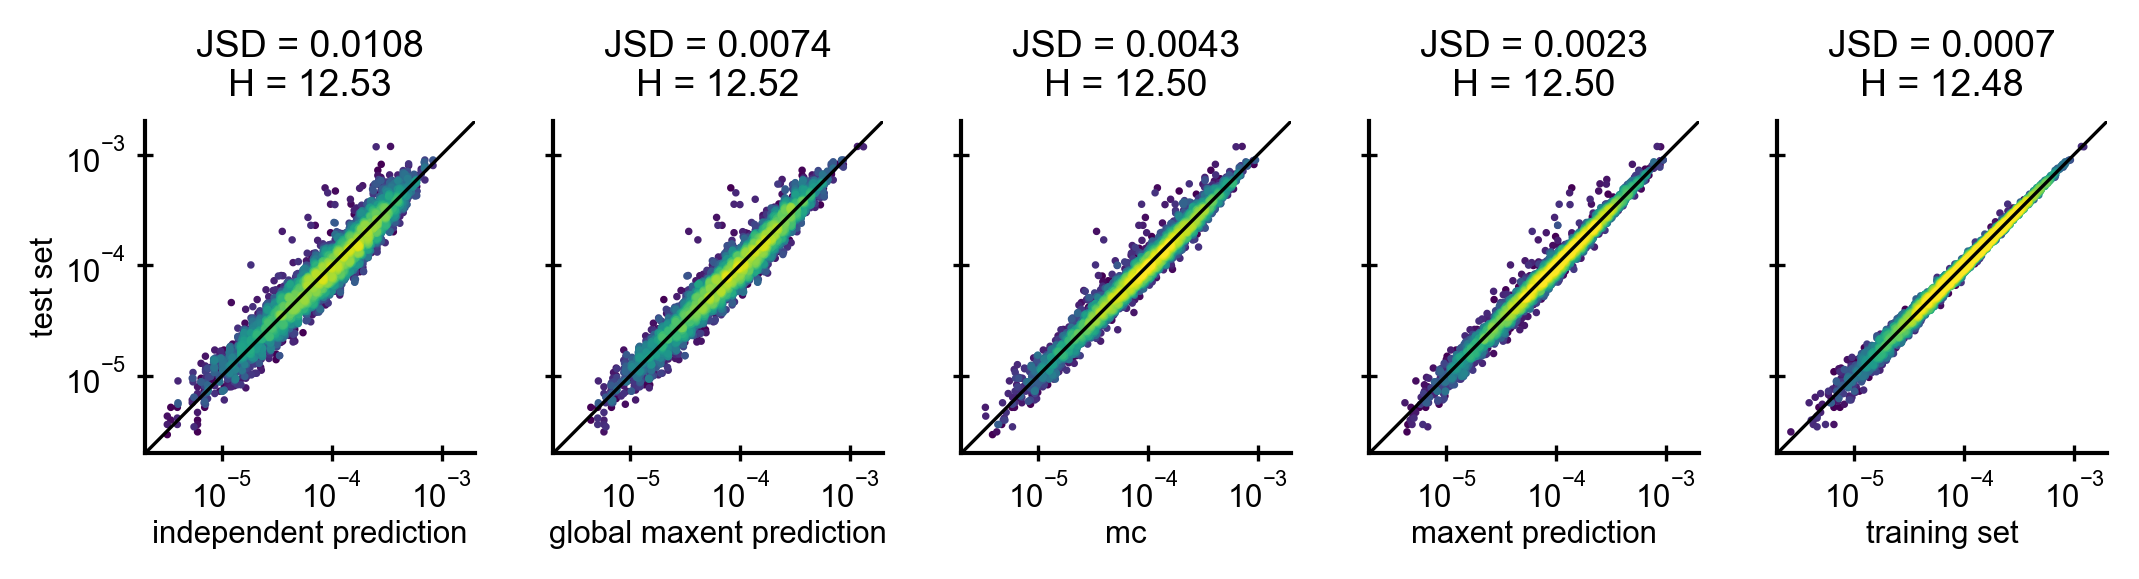

In [444]:
scatter = lambda x, y, ax: density_scatter(x, y, ax=ax, s=1, bins=100,
                                           trans=lambda x: np.log(x+1e-8),
                                           norm=matplotlib.colors.LogNorm(vmin=0.5, vmax=50 if k ==3 else 400),
                                           cmap='viridis')
#scatter = lambda x, y, ax: ax.scatter(x, y, s=1, alpha=1, edgecolor=None)

fig, axes = plt.subplots(figsize=(7.2, 2.0), ncols=5, sharex=True, sharey=True)
axes[0].set_ylabel('test set')

for ax, column, xlabel in [(axes[0], 'freq_ind','independent prediction'),
                           (axes[1], 'freq_maxentglobal', 'global maxent prediction'),
                           (axes[2], 'freq_mc', 'mc'),
                           (axes[3], 'freq_maxent', 'maxent prediction'),
                           (axes[4], 'freq', 'training set')
                            ]:
    scatter(df[column], df['freq_test'], ax)
    ax.set_xlabel(xlabel)
    jsd = calc_jsd(df['freq_test'], df[column], base=2)
    entropy = entropies[column]
    ax.set_title('JSD = {:.4f}\nH = {:.2f}'.format(jsd, entropy))
    
if k == 3:
    x = np.logspace(-5.7, -2.7)
elif k == 4:
    x = np.logspace(-7.7, -2.9)
for ax in axes:
    ax.plot(x, x, 'k', lw=0.8)
    ax.set_xlim(min(x), max(x))
    ax.set_ylim(min(x), max(x))
    ax.set_xscale('log')
    ax.set_yscale('log')
fig.tight_layout()
fig.savefig('main.png' if k == 3 else 'comparison_k4.png', dpi=600)

In [446]:
2**entropies['freq'], 2**entropies['freq_maxent'], 2**entropies['freq_ind'], 20**k

(5728.578236172637, 5800.633160515391, 5927.786266321473, 8000)

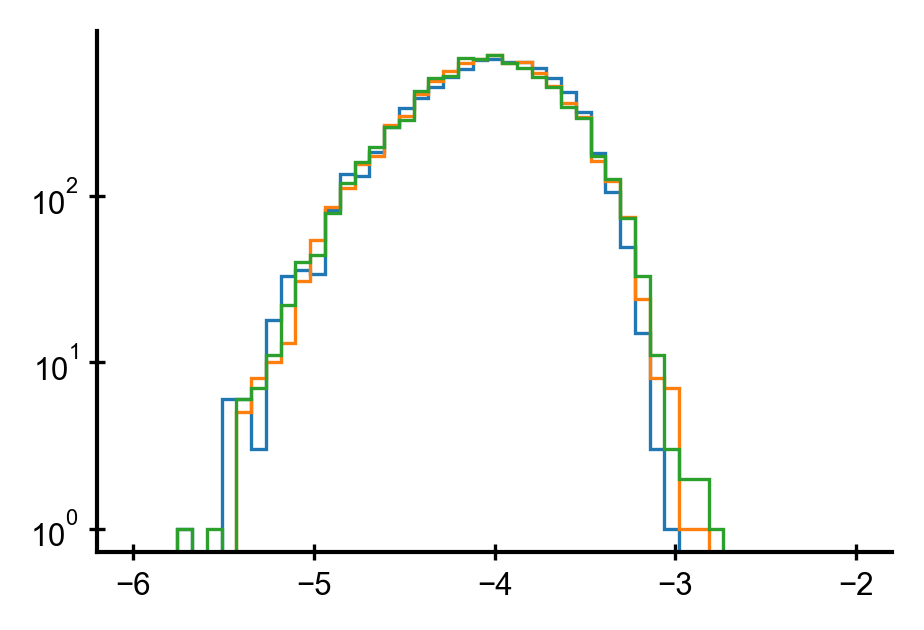

In [450]:
bins = np.linspace(-6, -2)
kwargs = dict(bins=bins, histtype='step')
plt.hist(np.log10(df['freq_ind']), **kwargs)
plt.hist(np.log10(df['freq_maxent']),**kwargs)
plt.hist(np.log10(df['freq']),**kwargs)
plt.yscale('log')